Imports

In [2]:
from __future__ import annotations

import random
from pathlib import Path
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Load Dataset

In [3]:
def load_mnist(flatten: bool = True) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    #Fetch MNIST via Keras and return train/test splits.

    from tensorflow.keras.datasets import mnist  # Lazy import

    (X_train, y_train), (X_test, y_test) = mnist.load_data()

    if flatten:
        X_train = X_train.reshape(-1, 28 * 28).astype(np.float32)
        X_test = X_test.reshape(-1, 28 * 28).astype(np.float32)

    return X_train, y_train, X_test, y_test

# Plot

In [15]:
def plot_2d(proj: np.ndarray, labels: np.ndarray, comps: Tuple[int, int], title: str) -> None:
    x_idx, y_idx = comps

    plt.figure(figsize=(7, 7))
    scatter = plt.scatter(
        proj[:, x_idx],
        proj[:, y_idx],
        c=labels,
        cmap="tab10",
        s=8,
        alpha=0.7,
        linewidths=0,
    )
    plt.colorbar(scatter, ticks=range(10))
    plt.title(title)
    plt.xlabel(f"PC{x_idx + 1}")
    plt.ylabel(f"PC{y_idx + 1}")
    plt.tight_layout()
    plt.show()  # Ekrana çiz


# PCA Implementation

In [5]:
def pca(X: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    # Center the data
    mean = X.mean(axis=0)
    X_centered = X - mean

    # Singular value decomposition – full_matrices=False for efficiency
    U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)

    # Eigenvalues from singular values (dividing by n‑1 for unbiased variance)
    n_samples = X.shape[0]
    weights = (S ** 2) / (n_samples - 1)

    # Principal directions are rows of V but we return column vectors
    vectors = Vt.T

    return mean, weights, vectors


def project(X: np.ndarray, mean: np.ndarray, vectors: np.ndarray, k: int) -> np.ndarray:
    # Project X onto the first k principal components
    if not (1 <= k <= vectors.shape[1]):
      raise ValueError(f"k={k} is out of bounds. Must be between 1 and {vectors.shape[1]}")
    return (X - mean) @ vectors[:, :k]

Test

Principal Component Size: 
(784, 784)

Cumulative explained variance (first 100 PCs):
PC01: 0.1056
PC06: 0.3826
PC11: 0.5123
PC16: 0.6001
PC21: 0.6615
PC26: 0.7076
PC31: 0.7452
PC36: 0.7759
PC41: 0.8005
PC46: 0.8210
PC51: 0.8385
PC56: 0.8533
PC61: 0.8660
PC66: 0.8772
PC71: 0.8869
PC76: 0.8956
PC81: 0.9034
PC86: 0.9103
PC91: 0.9165
PC96: 0.9220


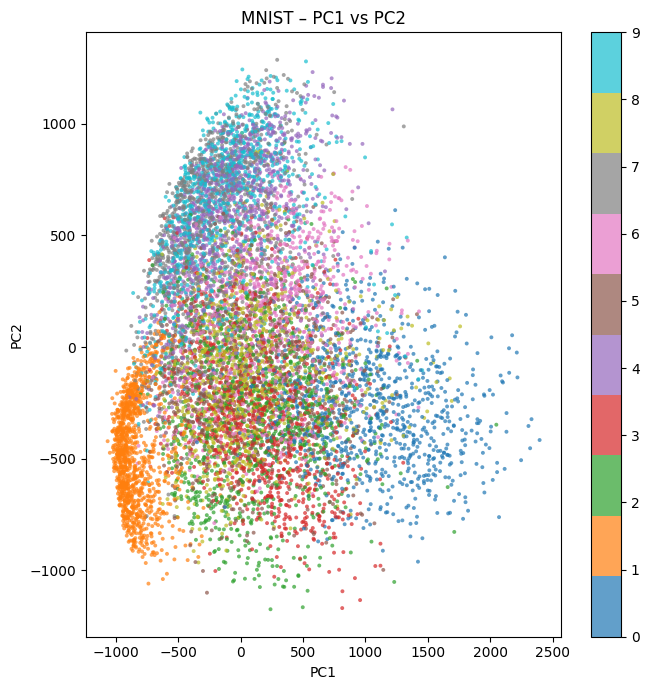

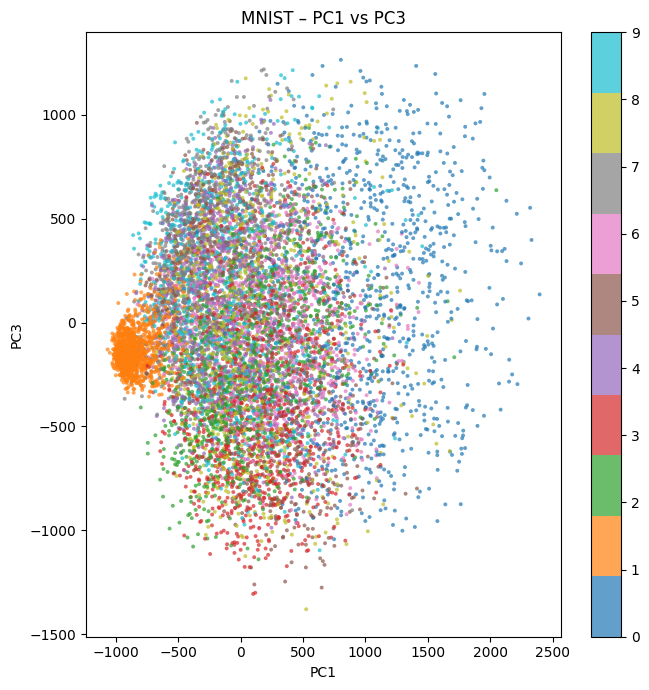

In [16]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

# Load data
X_train, y_train, X_test, y_test = load_mnist()

# --- Compute PCA on a random subset of 1000 training images -------------
subset_idx = np.random.choice(X_train.shape[0], 1000, replace=False)
mean, weights, vectors = pca(X_train[subset_idx])

print("Principal Component Size: ")
print(vectors.shape)
print()

# Print cumulative variance for reference (optional)
explained_variance_ratio = weights / weights.sum()
cumulative = np.cumsum(explained_variance_ratio)
print("Cumulative explained variance (first 100 PCs):")
for i in range(100):
  if i % 5 == 0:
      print(f"PC{i + 1:02d}: {cumulative[i]:.4f}")


# --- Visualization on test set ------------------------------------------
proj_test = project(X_test, mean, vectors, 3)  # first 3 PCs for all test samples

plot_2d(proj_test, y_test, (0, 1), "MNIST – PC1 vs PC2")
plot_2d(proj_test, y_test, (0, 2), "MNIST – PC1 vs PC3")



**Conclusion**\
The PCA transformation produced 784 principal components in total, corresponding to the original feature space of the MNIST dataset. However, the cumulative explained variance shows that the majority of information can be retained with significantly fewer components. Specifically, the first 50 components account 83% of the total variance, and the first 100 components explain more than 92%. This indicates that PCA effectively reduces dimensionality while preserving most of the essential structure of the data. Additionally, the 2D scatter plots for the first few principal components show visible separation between different digit classes, supporting the utility of PCA in both compression and visualization tasks.

In [17]:
# --- Classification experiment ------------------------------------------
n_components_list: List[int] = [10, 25, 50, 80]

print("\nRandom Forest performance after PCA dimensionality reduction:")
# Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

cv_results = {}  # Store results

for k in n_components_list:
    X_proj = project(X_train, mean, vectors, k)
    fold_scores = []

    for train_idx, val_idx in skf.split(X_proj, y_train):
        X_train_fold, X_val_fold = X_proj[train_idx], X_proj[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

        rf = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
        rf.fit(X_train_fold, y_train_fold)

        y_pred = rf.predict(X_val_fold)
        acc = accuracy_score(y_val_fold, y_pred)
        fold_scores.append(acc)

    mean_score = np.mean(fold_scores)
    std_score = np.std(fold_scores)
    cv_results[k] = mean_score

    print(f"  k = {k:3d} → accuracy = {mean_score:.4f} ± {std_score:.4f}")

best_k = max(cv_results, key=cv_results.get)

# Train and evaluate
rf_final = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)
X_train_best = project(X_train, mean, vectors, best_k)
rf_final.fit(X_train_best, y_train)

X_test_best = project(X_test, mean, vectors, best_k)
test_accuracy = accuracy_score(y_test, rf_final.predict(X_test_best))

print(f"\nSelected k = {best_k} (best CV). Test accuracy: {test_accuracy:.4f}")


Random Forest performance after PCA dimensionality reduction:
  k =  10 → accuracy = 0.9053 ± 0.0022
  k =  25 → accuracy = 0.9500 ± 0.0021
  k =  50 → accuracy = 0.9522 ± 0.0022
  k =  80 → accuracy = 0.9507 ± 0.0017

Selected k = 50 (best CV). Test accuracy: 0.9590


After applying PCA for dimensionality reduction, Random Forest classifiers were trained on various reduced feature sets. The highest cross-validation accuracy was achieved with 50 principal components, yielding an average score of 95.22% and a standard deviation of 0.22%. Notably, increasing the number of components beyond 50 did not lead to significant improvements, suggesting that most of the relevant information is captured within the first 50 components. When evaluated on the held-out test set, the model achieved an accuracy of 95.90%, confirming that the reduced-dimensional representation preserved enough discriminative power for effective classification.